# Udacity Project #1 - Best In Show

### Section 1: Business Understanding
Dogs are one of the most popular pets but not all dog breeds are a good fit for all people. Often when people no longer can care for a dog or it isn't the right fit they will seek out a local shelter or rescue organization. As a result here are a large number of highly intelligent breeds that need rehomed each year. This has only been exacerbated during the pandemic. This analysis aims to shed light on what it takes to own a brilliant dog by answering the following questions:

##### Question 1: Are the brightest dogs popular?
This question aims to address the market demand to see if people in the US are interested in having a smart dog.

##### Question 2: How affordable are intelligent dogs?
The question analyzes the ranges of costs across dog intelligence levels from the Brightest to the Lowest. The goal of this question is to identify if the cost of owning a smart dog leads to their incompatibility and needing to find a new home.

##### Question 3: Do intelligent dogs share similar traits and are they specific to a breed category?
This question aims to identify key traits that are typically associated with the brightest of breeds. It also aims to identify key breeds classes as each class has different needs.

In [232]:
# The relevant packages are imported below to perform the data analysis.
# Methods that will be used throughout the notebook have also been defined
# in this section.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score


def ConvertDfObjectsToNumeric(df, column_names_array):
    '''
    INPUT
    df - the pandas dataframe to be changed
    column_names_array - the column headings that are to be converted from object to float
    
    OUTPUT
    None
    '''
    # Convert remaning object types to floats
    for name in column_names_array:
        
        df[name] = pd.to_numeric(df[name], errors= 'coerce')

def CleanData(df):
    '''
    INPUT
    df - the pandas dataframe to be cleaned
    
    OUTPUT
    X - All of the variables you want to consider when predicting the response (matrix)
    y - The response variable (matrix)
    '''
    # Replace the 'no data' labels with NaNs
    df = df.replace('no data', np.nan)

    # Drop columns with all NaN values
    df = df.dropna(how='all', axis=1)

    # Remove missing intelligence and popularity nan rows
    df = df.dropna(subset = ['1 INTELLIGENCE (TRAINABILITY) ranking', 'POPULARITY IN US', 'intelligence category'])

    # Select the columns of interest
    new_df = df[['1 INTELLIGENCE (TRAINABILITY) ranking', 'POPULARITY IN US', 'LIFETIME COST, $', 
    '5b suitability for children ', '2 LONGEVITY', '5a grooming required ', '4a average purchase price, US$', 
    'category', 'intelligence category']]

    # For quantitative variables, replace NaN values with the mean of that column
    quantitativeVariables = new_df.select_dtypes(include=['float', 'int']).columns
    for column in quantitativeVariables:
        new_df[column].fillna((new_df[column].mean()), inplace=True)
    
    return new_df

def CreateDummyDf(df, categorical_columns, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to get dummy variablesf for
    categorical_columns - the names of the categorical columns (list of strings)
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe with only the dummy variable columns
    '''
    for column in  categorical_columns:
        try:
            # for each cat add dummy var, drop original column
            df = pd.concat([df.drop(column, axis=1), pd.get_dummies(df[column], prefix=column, prefix_sep='_', drop_first=True, dummy_na=dummy_na)], axis=1)
        except:
            continue
    return df

### Section 2: Data Understanding
Gather the Data

In [233]:
# This section is where the dataframe is loaded in for future cleaning and analysis.
# The data consist of information regarding dog breeds, costs, intelligence, popularity, etc.

filepath = 'C:/Repositories/Udacity_Best_In_Show/best_in_show.csv'
df = pd.read_csv(filepath)

### Section 3: Data Preparation
This step focuses on replacing or removing NaNs in our dataset and converting  datatypes into a usable format for our analysis.

In [234]:
# This dataset currently has all datatypes listed as objects. We will need
# to remove the '$' from the cost columns and then convert them to numerics.
# This achieved by replacing any instance of '$' with an empty space.

df[df.columns[1:]] = df[df.columns[1:]].replace('[\$,]', '', regex=True)

columnNames = ['1 INTELLIGENCE (TRAINABILITY) ranking', 'POPULARITY IN US', 'LIFETIME COST, $', '2 LONGEVITY', '4a average purchase price, US$']
ConvertDfObjectsToNumeric(df, columnNames)

# The data lists '-' instead of NaN for some values. Using the same logic as above
# we replaced the '-' with a NumPy NaN value so that we can more easily clean the data
# in the following sections.
df[df.columns[1:]] = df[df.columns[1:]].replace('-', np.nan, regex=True)

# Create cleaned dataset for quantitative variables
cleaned_df = CleanData(df)

# Clean the data for the categorical NaNs (drop missing values for children suitability)
# These values were dropped because there were over 24% of the values missing. 
# Also, the rows that were missing "5b suitability for children" also were missing "grooming required" data
# The combination of the small data set and multiple missing values led me to drop the rows
cleaned_df = cleaned_df.dropna(subset = ['5b suitability for children '])

# Create dummy values for 'category'
# Dummy values were created for category as there only were 10% of the values missing. By creating dummy
# values I was able to keep the rows and have a sample size of 100 data points. 
columnList = ['category']
cleaned_df = CreateDummyDf(cleaned_df, columnList, True)

# Check for NaN values
print("Percentage of missing values:")
print(cleaned_df.isna().sum()/len(cleaned_df))

Percentage of missing values:
1 INTELLIGENCE (TRAINABILITY) ranking    0.0
POPULARITY IN US                         0.0
LIFETIME COST, $                         0.0
5b suitability for children              0.0
2 LONGEVITY                              0.0
5a grooming required                     0.0
4a average purchase price, US$           0.0
intelligence category                    0.0
category_hound                           0.0
category_sporting                        0.0
category_terrier                         0.0
category_toy                             0.0
category_working                         0.0
category_nan                             0.0
dtype: float64


In [235]:
# Create sub df for Brightest, Excellent, Average, Fair, and Lowest intelligence levels
excellentPopularity = cleaned_df[cleaned_df['intelligence category'] == 'Excellent'][['POPULARITY IN US', 'LIFETIME COST, $']]
brightestPopularity = cleaned_df[cleaned_df['intelligence category'] == 'Brightest'][['POPULARITY IN US', 'LIFETIME COST, $']]
averagePopularity = cleaned_df[cleaned_df['intelligence category'] == 'Average'][['POPULARITY IN US', 'LIFETIME COST, $']]
fairPopularity = cleaned_df[cleaned_df['intelligence category'] == 'Fair'][['POPULARITY IN US', 'LIFETIME COST, $']]
lowestPopularity = cleaned_df[cleaned_df['intelligence category'] == 'Lowest'][['POPULARITY IN US', 'LIFETIME COST, $']]

### Section 4: Evaluate the Results

#### Are the brightest dogs popular?
A bar graph of each intelligence category was chosen to visualize the popularities. A bar chart was chosen for its easy to interpret nature and ability to clearly depict how each intelligence measured in popularity against one another. A two-tailed t-test was performed to check for statistical significance between groups.

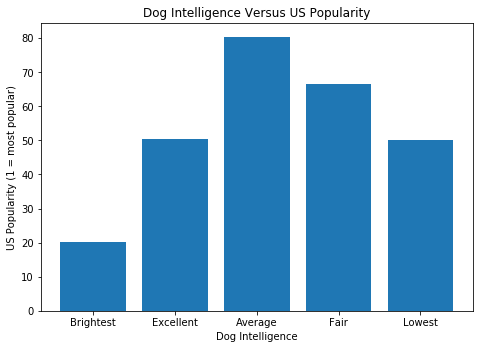

,Intelligence,Brightest,Excellent
0,Brightest,-,0.0438685
1,Excellent,0.0438685,-
2,Average,0.00170491,0.0778621
3,Fair,0.00378943,0.303769
4,Lowest,0.0307391,0.987572


In [236]:
# Plot the average popularity (1 = most popular) against dog intelligence
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
intelligence = ['Brightest', 'Excellent', 'Average', 'Fair', 'Lowest']
popularity = [
    brightestPopularity['POPULARITY IN US'].mean(),
    excellentPopularity['POPULARITY IN US'].mean(),
    averagePopularity['POPULARITY IN US'].mean(),
    fairPopularity['POPULARITY IN US'].mean(),
    lowestPopularity['POPULARITY IN US'].mean()]

ax.bar(intelligence,popularity)
ax.set_title('Dog Intelligence Versus US Popularity')
ax.set_ylabel('US Popularity (1 = most popular)')
ax.set_xlabel('Dog Intelligence')
plt.show()

# Use a t-test to compare differences between groups
# Brightest v Other Groups
_, pBrightestExcellent = ttest_ind(brightestPopularity['POPULARITY IN US'], excellentPopularity['POPULARITY IN US'])
_, pBrightestAverage = ttest_ind(brightestPopularity['POPULARITY IN US'], averagePopularity['POPULARITY IN US'])
_, pBrightestFair = ttest_ind(brightestPopularity['POPULARITY IN US'], fairPopularity['POPULARITY IN US'])
_, pBrightestLowest = ttest_ind(brightestPopularity['POPULARITY IN US'], lowestPopularity['POPULARITY IN US'])

# Excellent v Other Groups
_, pExcellentAverage = ttest_ind(excellentPopularity['POPULARITY IN US'], averagePopularity['POPULARITY IN US'])
_, pExcellentFair = ttest_ind(excellentPopularity['POPULARITY IN US'], fairPopularity['POPULARITY IN US'])
_, pExcellentLowest = ttest_ind(excellentPopularity['POPULARITY IN US'], lowestPopularity['POPULARITY IN US'])

# create a dataframe to display the p-values of interest
data = {
    'Intelligence': ['Brightest', 'Excellent', 'Average', 'Fair', 'Lowest'],
    'Brightest': ['-', pBrightestExcellent, pBrightestAverage, pBrightestFair, pBrightestLowest],
    'Excellent': [pBrightestExcellent,'-', pExcellentAverage, pExcellentFair, pExcellentLowest]
}

pValueDataFrame = pd.DataFrame(data = data)
pValueDataFrame

The figure above shows us that the Brightest dog breeds are the most popular in the US by at least 2 fold when compared to other intellegence levels. This indicates that people do want smart dogs and leads to our next question of is cost a limiting factor.

#### How affordable are intelligent dogs?

This question starts to dive into why the Brightest dogs are so popular with there being no difference between the lowest intelligent and next smartest dogs. Here, a scatter plot was used to visualize trends between dog intelligence levels, lifetime cost, and popularity in the US.

Text(0.5, 1.0, 'Dog Popularity as a Function of Cost')

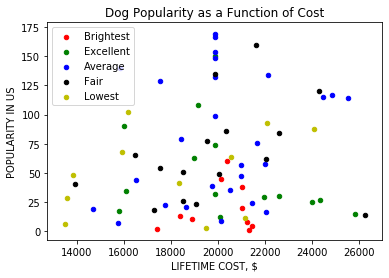

In [237]:
# Create plots to display intelligence group cost values
ax1 = brightestPopularity.plot(kind='scatter', y='POPULARITY IN US', x='LIFETIME COST, $', color='r')
ax2 = excellentPopularity.plot(kind='scatter', y='POPULARITY IN US', x='LIFETIME COST, $', color='g', ax=ax1)    
ax3 = averagePopularity.plot(kind='scatter', y='POPULARITY IN US', x='LIFETIME COST, $', color='b', ax=ax1)
ax4 = fairPopularity.plot(kind='scatter', y='POPULARITY IN US', x='LIFETIME COST, $', color='k', ax=ax1)    
ax5 = lowestPopularity.plot(kind='scatter', y='POPULARITY IN US', x='LIFETIME COST, $', color='y', ax=ax1)

plt.legend(['Brightest','Excellent','Average', 'Fair', 'Lowest'])
plt.title('Dog Popularity as a Function of Cost')

A scatter plot was chosen do visualize the different costs per intelligence grouping because of its ability to illustrate trends among groups for easy comparison. Here, we see that the Brightest dog category (red) has the tightest spread when compared to the other groups. However, the cost is centered around the median lifetime cost for all breeds and does not appear to depend on intellegence or popularity.

#### What key features are parameters do most of the Brightest dogs have?
Here, I created a logistic regression model to determine what (if any) parameters are associated with the Brightest intelligence breeds. A logistic regression was used instead of a linear regression because the response variable is catagorical in nature. Also, since we are only interested in what predictors contribute to the Brightest breeds the Brightest Intelligence level was assigned a 1 and the remaining levels 0.

In [239]:
# Convert response variable to binary values. We only care about the Brightest intelligence level and so it has been assigned 1 and the other categories a 0.
cleaned_df['intelligence category'] = cleaned_df['intelligence category'].replace(['Excellent','Above average','Average','Fair', 'Lowest'],0,regex=True)
cleaned_df['intelligence category'] = cleaned_df['intelligence category'].replace(['Brightest'],1,regex=True)

# Specify predictor variable column names
columnPredictorList =  ['5b suitability for children ','5a grooming required '
, '2 LONGEVITY','category_hound', 'category_sporting', 'category_terrier',
'category_toy', 'category_working']

In [264]:
# Begin setting up the logistic regression

# Set predictor and response variables
x = cleaned_df[columnPredictorList]
y = cleaned_df['intelligence category']

# Split into train and test data sets
X_train, X_test, y_train, y_test = train_test_split(x, y, 
test_size = 0.2, random_state=13)
logreg = LogisticRegression(solver='lbfgs')

# Predict and score the model
predicted = cross_val_predict(logreg, X_train, y_train, cv=10)

clf = logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

# Display the test and training scores
print('The training score is: ', accuracy_score(y_train, predicted))
print('The test score is: ', accuracy_score(y_test, y_pred))

# Create a dataframe to display the coeficient values

coefficients = list(clf.coef_[0])
coefficients[0]

coefficientData = {
    'Suitability for Children': [coefficients[0]],
    'Grooming Required': [coefficients[1]],
    'Longevity': [coefficients[2]],
    'Hound': [coefficients[3]],
    'Sporting': [coefficients[4]],
    'Terrier': [coefficients[5]],
    'Toy': [coefficients[6]],
    'Working': [coefficients[7]]
}

coefficientDataFrame = pd.DataFrame(data = coefficientData)

# Display the results
coefficientDataFrame

The training score is:  0.8875
The test score is:  0.9


c:\Users\MALIK\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:667: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)


,Suitability for Children,Grooming Required,Longevity,Hound,Sporting,Terrier,Toy,Working
0,0.87893,0.640804,0.149487,-0.708754,0.280482,-0.670466,-0.359801,0.408523


The training score of 0.88 and a test score of 0.9 indicate that the logistic regression model is able to capture whether or not a dog is the brightest based on the predictor parameters about 90% of the time. It should be noted that there were 100 data points used for this model which could potentially result in overfitting due to a small sample size. I would recommend future analysis given multiple data sources in subsequent studies.

The coefficients indicate that the most intelligent breeds are more likely to be good with children but also will require substantial grooming. The model also indicates a relationship between breed category and intelligence. Here, we see that the sporting and working categories tend to have a stronger correlation with intelligence when compared to hound, terrier, and toy breeds that have a negative coefficient.